In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
%matplotlib inline


In [2]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 20.0
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
import pickle

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from graph_learning_utils import *

# Algo questions

* should x_i be plus not minus? 

* ~~look at spectrum of the random matrices~~

* ~~try different distributions for sample data~~

* tune delta on synthetic data. 

* ~~g1 and g2 idea~~

## check spectra

In [6]:
sample_mats = generate_synthetic_data(20, 5)

In [9]:
all_sample_eigs = []
for mat in sample_mats:
    all_sample_eigs += list(np.linalg.eigvals(mat))

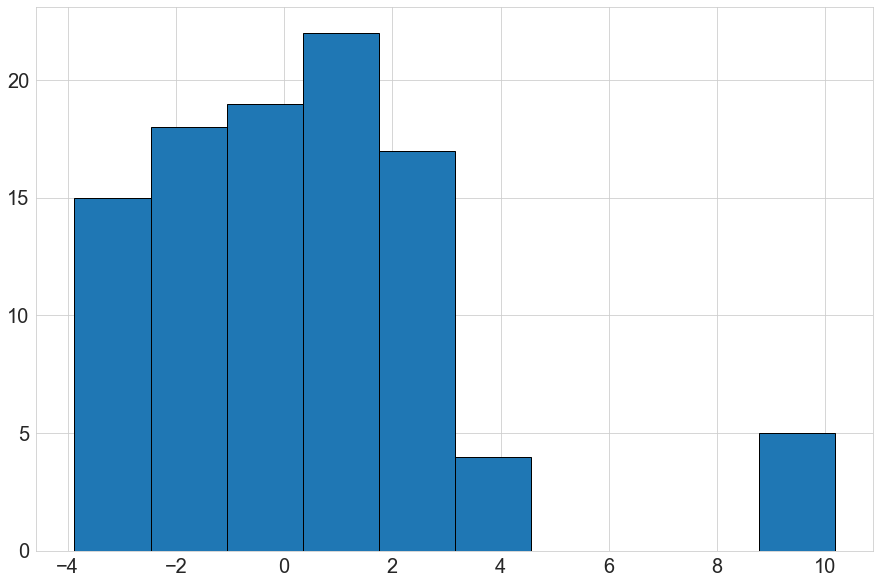

In [12]:
plt.hist(all_sample_eigs, bins=10, ec='k');

In [16]:
all_eigs_ground_truth = []
for _ in range(100): 
    ground_truth_mat = generate_ground_truth_mat(20)
    all_eigs_ground_truth += list(np.linalg.eigvals(ground_truth_mat))

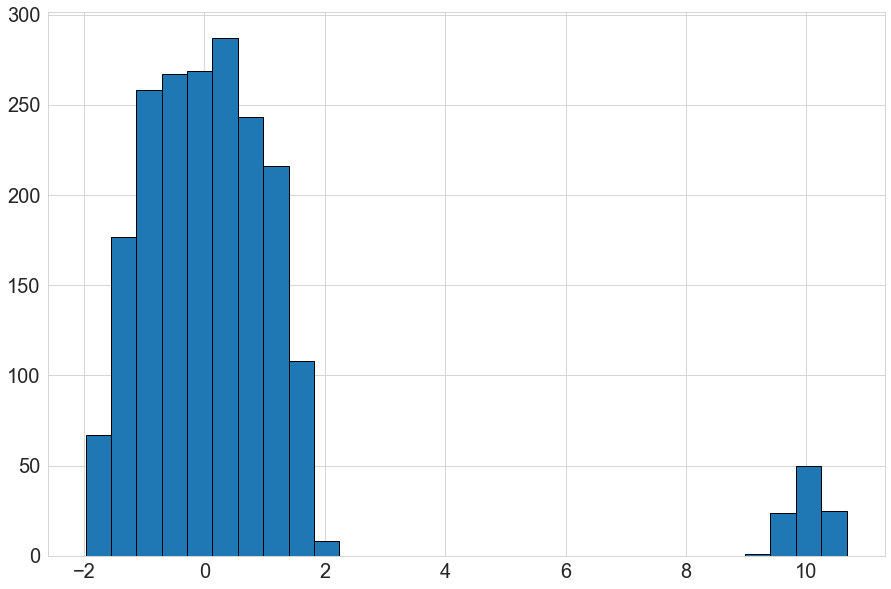

In [18]:
plt.hist(all_eigs_ground_truth, bins=30, ec='k');

In [19]:
all_eigs_ground_truth = []
for _ in range(100): 
    ground_truth_mat = generate_ground_truth_mat(200)
    all_eigs_ground_truth += list(np.linalg.eigvals(ground_truth_mat))

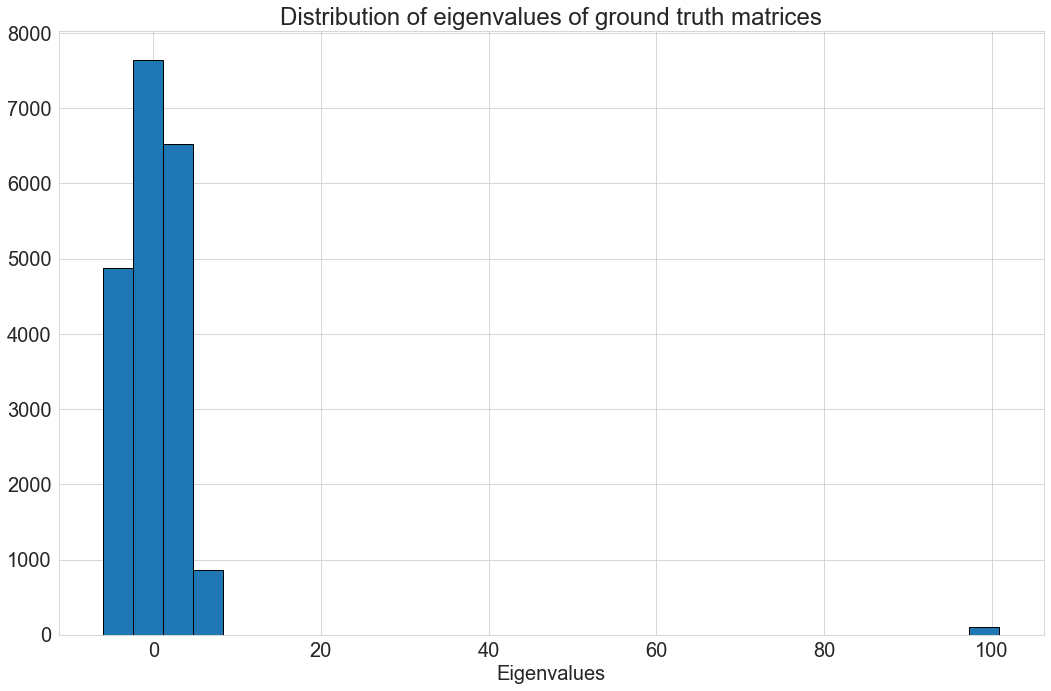

In [33]:
plt.hist(all_eigs_ground_truth, bins=30, ec='k');
plt.title('Distribution of eigenvalues of ground truth matrices');
plt.xlabel('Eigenvalues')
plt.tight_layout()
plt.savefig('figs/eigenvalues_ground_truth.png', dpi=300);

In [25]:
sorted(all_eigs_ground_truth[-200:])[-5:]

[5.121138862158043,
 5.321423671517005,
 5.399453983555429,
 5.596352089101836,
 100.34303090118945]

Takeaway 1: The spectra of our initial model does seem to be following a Marchenko Pastur distribution.

See also this link: https://mathoverflow.net/questions/356989/singular-values-of-random-uniform-matrix

# Testing synthetic data with different distributions

Wigner? No, because the distribution has to be between [0, 1] for each entry. It must represent a probability. 

Wishart? Well, we know Wishart is PSD, but again does it belong to [0, 1]? 

Let's try the G1 and G2 idea. 

## control the eigenvalues

A simpler idea is to just generate a random orthogonal matrix and then enforce certain eigenvalues.

In [37]:
def generate_mat_from_eigs(eigs): 
    '''
    Generate a matrix from a list of eigenvalues
    '''
    eigenbasis_matrix = scipy.stats.ortho_group.rvs(len(eigs))
    eigvals_matrix = np.diag(eigs)
    mat = eigenbasis_matrix @ eigvals_matrix @ eigenbasis_matrix.T

    return mat, eigenbasis_matrix

In [106]:
def generate_sample_mats_from_mat(mat, num_samples): 
    '''
    Generate sample matrices from a ground truth matrix
    '''
    def gen_sample_normal_mat(ground_truth_mat): 
        n = ground_truth_mat.shape[0]
        A = np.zeros_like(ground_truth_mat)
        for i in range(n):
            for j in range(i + 1):
                sample = np.random.normal(ground_truth_mat[i, j], 0.1)
                A[i, j] = sample
                A[j, i] = sample
        return A
    sample_mats = [gen_sample_normal_mat(mat) for _ in range(num_samples)]
    return sample_mats

In [39]:
generate_mat_from_eigs([0.1, 0.1, 0.2, 3, 3.1])

(array([[ 1.86739295,  0.05631699,  1.3278541 , -0.56546232,  0.11500246],
        [ 0.05631699,  0.12467141,  0.04322099, -0.08963919,  0.03326244],
        [ 1.3278541 ,  0.04322099,  1.43354756,  0.07020057, -0.66483109],
        [-0.56546232, -0.08963919,  0.07020057,  1.24315441, -1.24475569],
        [ 0.11500246,  0.03326244, -0.66483109, -1.24475569,  1.83123367]]),
 array([[-0.20229215,  0.48673699,  0.36440047,  0.37440184,  0.67022425],
        [ 0.68490099,  0.57129684, -0.45059408,  0.03444876,  0.01757292],
        [ 0.3741321 , -0.61740355, -0.1884283 , -0.00371153,  0.66582207],
        [ 0.40265021,  0.08360006,  0.67256293, -0.61407264,  0.03818038],
        [ 0.43345877, -0.2202973 ,  0.41991804,  0.69392907, -0.32513671]]))

Aha. Note that this is still unrealistic given that the entries of the matrix are not all nonnegative. 

## sum of two iid uniform(0,1) mats

In [40]:
mat1, mat2 = generate_ground_truth_mat(20), generate_ground_truth_mat(20)

In [42]:
mat = 0.5 * mat1 + 0.5 * mat2

In [50]:
scipy.linalg.eigh(mat1, eigvals_only=True)

array([-1.58478588, -1.16598388, -1.118625  , -0.9851427 , -0.85010947,
       -0.78018751, -0.51698121, -0.25501207, -0.16317257,  0.03580316,
        0.27923595,  0.40567144,  0.55087407,  0.65887241,  0.9078812 ,
        1.14358634,  1.26929345,  1.41587643,  1.94880596,  9.49471085])

In [51]:
scipy.linalg.eigh(mat, eigvals_only=True)

array([-1.03659243, -0.89715771, -0.8151393 , -0.72354805, -0.59160819,
       -0.43376835, -0.37600509, -0.29978909, -0.17284775,  0.09162469,
        0.13296914,  0.29461071,  0.3557457 ,  0.42455559,  0.77572276,
        0.81686067,  0.9419122 ,  1.16494351,  1.51643124,  9.731124  ])

In [57]:
np.linalg.eig(mat1)[1][:, -1].T @ np.linalg.eig(mat2)[1][:, -1]

0.07825650784961152

Okay, the eigenvectors are pretty close to orthogonal. But still, the eigenvalues of the average don't work.

In [59]:
scipy.linalg.eigh(0.2 * mat1 + 0.8 * mat2, eigvals_only=True)

array([-1.22304839, -1.09292471, -0.95939964, -0.76001606, -0.68785393,
       -0.42270317, -0.32033489, -0.24150782, -0.15229284, -0.03071145,
        0.21789972,  0.34562499,  0.45831464,  0.65658028,  0.75206867,
        0.91962658,  0.97340588,  1.21977139,  1.46978828,  9.90341666])

Okay, the use of averaging two samples doesn't solve the top eigenvalue problem. 

## distribution with two large eigenvalues

I'm not sure what kind of matrix has the following: 

* Nonnegative entries within [0, 1].

* Symmetric (although, I could symmetrize easily enough)

* Two large eigenvalues.

Adding a small constant to the diagonal doesn't work. 

Maybe I can try varying the diagonal entries.

### add to the diagonal

In [88]:
mat = generate_ground_truth_mat(20)

In [89]:
diag_entries = [np.random.uniform(0, 5 * k) for k in range(1, 21)]
mat += np.diag(diag_entries)

In [90]:
scipy.linalg.eigh(mat, eigvals_only=True)

array([ 0.98747057,  1.95844385,  4.70733673,  9.95278196, 13.46646131,
       16.18115929, 18.21379801, 20.18196038, 22.98605145, 29.14911474,
       34.35682888, 38.25350112, 41.10402983, 48.9256814 , 54.43624788,
       63.7060569 , 68.97681046, 70.33264491, 79.33947294, 81.9461401 ])

Okay, good. Let's formalize that and normalize the matrix, then try running some tests.

In [91]:
mat *= (1 / np.max(mat))

In [92]:
scipy.linalg.eigh(mat, eigvals_only=True)


array([0.01211385, 0.02402532, 0.05774752, 0.12209631, 0.16520057,
       0.19850328, 0.22343879, 0.24758333, 0.28198268, 0.3575884 ,
       0.42147433, 0.46927697, 0.50424599, 0.60019854, 0.66779973,
       0.78151763, 0.84617689, 0.86280967, 0.97330144, 1.00527887])

In [93]:
def generate_skewed_ground_truth(n): 
    mat = generate_ground_truth_mat(n)
    diag_entries = [np.random.uniform(0, 5 * k) for k in range(1, n + 1)]
    mat += np.diag(diag_entries)
    mat *= (1 / np.max(mat))
    return mat

<AxesSubplot:>

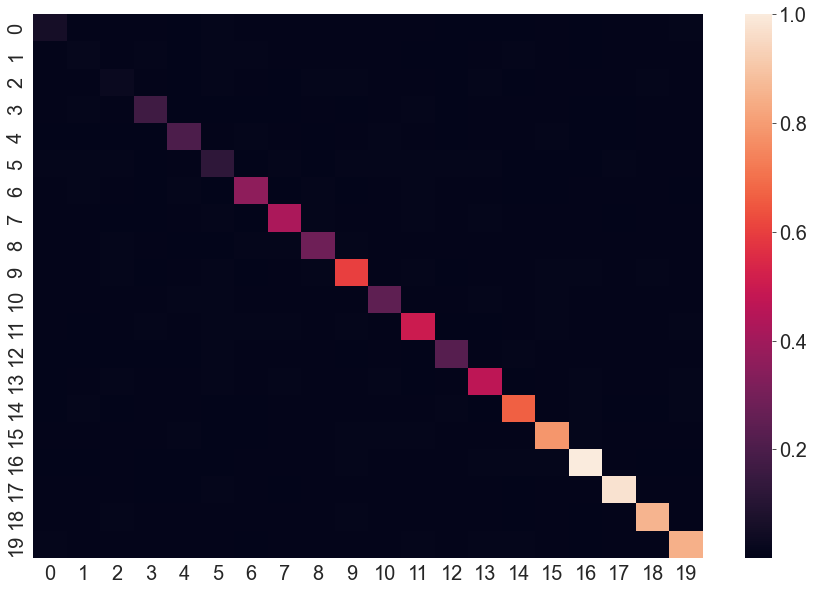

In [96]:
sns.heatmap(mat)

Aha! The issue is that we essentially get a diagonal matrix, which is useless. What we need is something that is still dense. 

## barabasi albert

In [100]:
G = nx.barabasi_albert_graph(50, 5)
adj = nx.to_numpy_array(G)

In [101]:
scipy.linalg.eigh(adj, eigvals_only=True)

array([-5.34947015, -4.95603713, -4.5631282 , -4.15636682, -3.82504297,
       -3.756855  , -3.36163887, -3.29280037, -2.80548859, -2.64632768,
       -2.63033134, -2.29520103, -2.17997121, -1.87315721, -1.64250122,
       -1.56624125, -1.21346429, -1.07559856, -0.98763857, -0.78088648,
       -0.7118797 , -0.52788546, -0.37619741, -0.24619363, -0.18966382,
       -0.04089839,  0.04818322,  0.25309122,  0.31034936,  0.50456667,
        0.67473731,  0.7780522 ,  0.93215195,  1.09160051,  1.25657029,
        1.42573149,  1.56636218,  1.76633497,  2.14175298,  2.20338456,
        2.51691709,  2.78841415,  2.98164469,  3.10334549,  3.22209798,
        3.61726685,  3.75438429,  4.13256122,  4.45624509, 11.52511962])

No! Still a big spectral gap.

# Try out on power law matrix (unrealistic)

In [113]:
def gen_data_unif_eigs(n, m): 
    ground_eigs = np.random.uniform(0, 1, n)
    ground_truth_mat, ground_truth_eigvecs = generate_mat_from_eigs(ground_eigs)
    sample_mats = generate_sample_mats_from_mat(ground_truth_mat, m)
    return sample_mats, ground_truth_mat, ground_truth_eigvecs

In [131]:
def gen_data_top_2_eigs(n, m):
    ground_eigs = np.array(list(np.random.uniform(0.99, 1, 2)) + list(np.random.uniform(0, 0.01, n - 2)))
    ground_truth_mat, ground_truth_eigvecs = generate_mat_from_eigs(
        ground_eigs)
    sample_mats = generate_sample_mats_from_mat(ground_truth_mat, m)
    return sample_mats, ground_truth_mat, ground_truth_eigvecs

In [114]:
def objective(eta_arr): 
    eigs = scipy.linalg.eigh(matrix_lin_combo(eta_arr, sample_mats), eigvals_only=True)
    ob_fn = lambda k: sum(eigs[-k:]) - k * delta
    ob1 = ob_fn(1)
    ob2 = ob_fn(2)

    ob1_bool = (ob1 >= ob2)
    # print('objective 1 is larger: ', ob1_bool)
    # print('obj 1 is ', ob1)
    # print('obj 2 is ', ob2)
    if ob1 < 0: 
        return 0.0
    return max(ob1, ob2)

def derivative(eta_arr): 
    eigvals, eigvecs = scipy.linalg.eigh(matrix_lin_combo(eta_arr, sample_mats))
    X_arrs_unscaled = [sample_mats[i] - sample_mats[0] if i !=0 else sample_mats[0] for i in range(len(sample_mats))]

    # list of lists 
    all_quad_forms = np.array([(eigvecs.T @ X_arrs_unscaled[i] @ eigvecs.T).sum(axis=1) for i in range(len(X_arrs_unscaled))])
    deriv_lambda_k = lambda k: all_quad_forms[:, k]

    if ob1_bool: 
        return deriv_lambda_k(1)
    else: 
        return deriv_lambda_k(2)

In [115]:
n = 50 
all_scores_dict = {}
for m in [2, 3, 4, 5]: 
    cur_scores = []
    for _ in range(100): 
        sample_mats, ground_truth_mat, ground_truth_eigvecs = gen_data_unif_eigs(n, m)
        delta = get_delta(sample_mats[0])
        ob1_bool = True 

        eta_init = np.random.uniform(0, 1, len(sample_mats))
        eta_init = eta_init / np.sum(eta_init)

        result = scipy.optimize.minimize(
            objective,
            eta_init,
            method='SLSQP',
            jac=derivative,
            bounds=[(0, 1) for _ in range(len(sample_mats))],
            constraints={'type': 'eq', 'fun': simplex_constraint},
            options={
                'maxiter': 10000,
                'disp': False
            }
        )

        score = scipy.linalg.eigh(matrix_lin_combo(result['x'], sample_mats), eigvals_only=True)[-1] - delta
        if score > 0: 
            ob_value = result['fun']
            cur_scores.append(ob_value)
        else: 
            cur_scores.append(score)

    all_scores_dict[m] = cur_scores
    print('finished m = ', m)

finished m =  2
finished m =  3
finished m =  4
finished m =  5


In [119]:
delta

0.7891750961462994

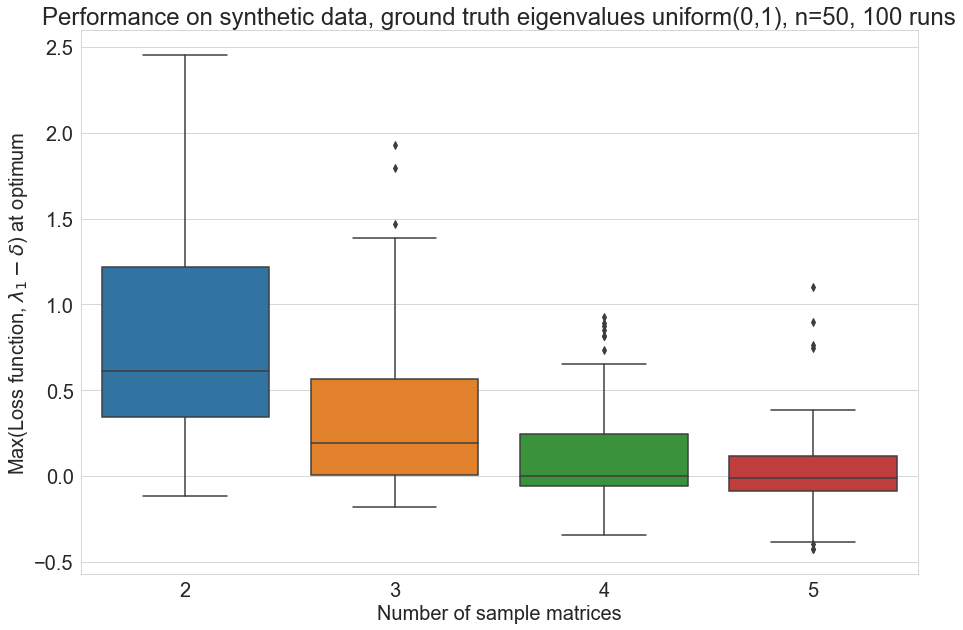

In [121]:
sns.boxplot(data=pd.DataFrame(all_scores_dict))
plt.ylabel('Max(Loss function, $\lambda_1 - \delta$) at optimum')
plt.xlabel('Number of sample matrices')
plt.title('Performance on synthetic data, ground truth eigenvalues uniform(0,1), n=50, 100 runs')
plt.savefig('figs/synthetic_data_unif_eigs.png')

In [126]:
n = 50 
all_scores_dict_zero_delta = {}
for m in [2, 3, 4, 5]: 
    cur_scores = []
    for _ in range(100): 
        sample_mats, ground_truth_mat, ground_truth_eigvecs = gen_data_unif_eigs(n, m)
        delta = 0.0
        ob1_bool = True 

        eta_init = np.random.uniform(0, 1, len(sample_mats))
        eta_init = eta_init / np.sum(eta_init)

        result = scipy.optimize.minimize(
            objective,
            eta_init,
            method='SLSQP',
            jac=derivative,
            bounds=[(0, 1) for _ in range(len(sample_mats))],
            constraints={'type': 'eq', 'fun': simplex_constraint},
            options={
                'maxiter': 10000,
                'disp': False
            }
        )

        score = scipy.linalg.eigh(matrix_lin_combo(result['x'], sample_mats), eigvals_only=True)[-1] - delta
        if score > 0: 
            ob_value = result['fun']
            cur_scores.append(ob_value)
        else: 
            cur_scores.append(score)

    all_scores_dict_zero_delta[m] = cur_scores
    print('finished m = ', m)


finished m =  2
finished m =  3
finished m =  4
finished m =  5


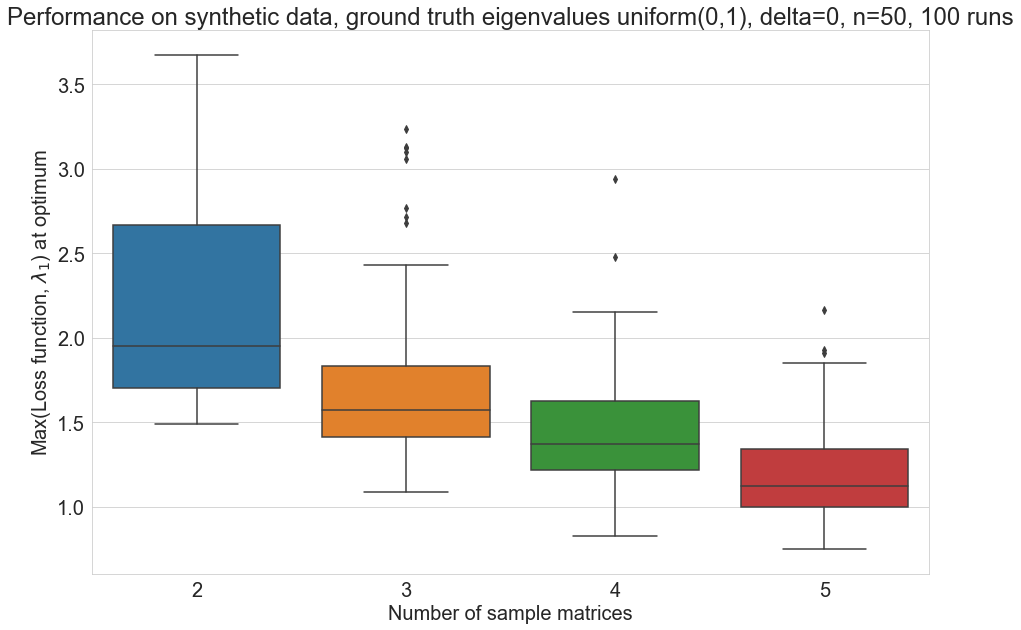

In [130]:
sns.boxplot(data=pd.DataFrame(all_scores_dict_zero_delta))
plt.ylabel('Max(Loss function, $\lambda_1$) at optimum')
plt.xlabel('Number of sample matrices')
plt.title('Performance on synthetic data, ground truth eigenvalues uniform(0,1), delta=0, n=50, 100 runs')
plt.savefig('figs/synthetic_data_unif_eigs_zero_delta.png')

### skew with top 2 eigs

In [132]:
n = 50 
all_scores_dict_skewed_eigs = {}
for m in [2, 3, 4, 5]: 
    cur_scores = []
    for _ in range(100): 
        sample_mats, ground_truth_mat, ground_truth_eigvecs = gen_data_top_2_eigs(n, m)
        delta = 0.0
        ob1_bool = True 

        eta_init = np.random.uniform(0, 1, len(sample_mats))
        eta_init = eta_init / np.sum(eta_init)

        result = scipy.optimize.minimize(
            objective,
            eta_init,
            method='SLSQP',
            jac=derivative,
            bounds=[(0, 1) for _ in range(len(sample_mats))],
            constraints={'type': 'eq', 'fun': simplex_constraint},
            options={
                'maxiter': 10000,
                'disp': False
            }
        )

        score = scipy.linalg.eigh(matrix_lin_combo(result['x'], sample_mats), eigvals_only=True)[-1] - delta
        if score > 0: 
            ob_value = result['fun']
            cur_scores.append(ob_value)
        else: 
            cur_scores.append(score)

    all_scores_dict_skewed_eigs[m] = cur_scores
    print('finished m = ', m)


finished m =  2
finished m =  3
finished m =  4
finished m =  5


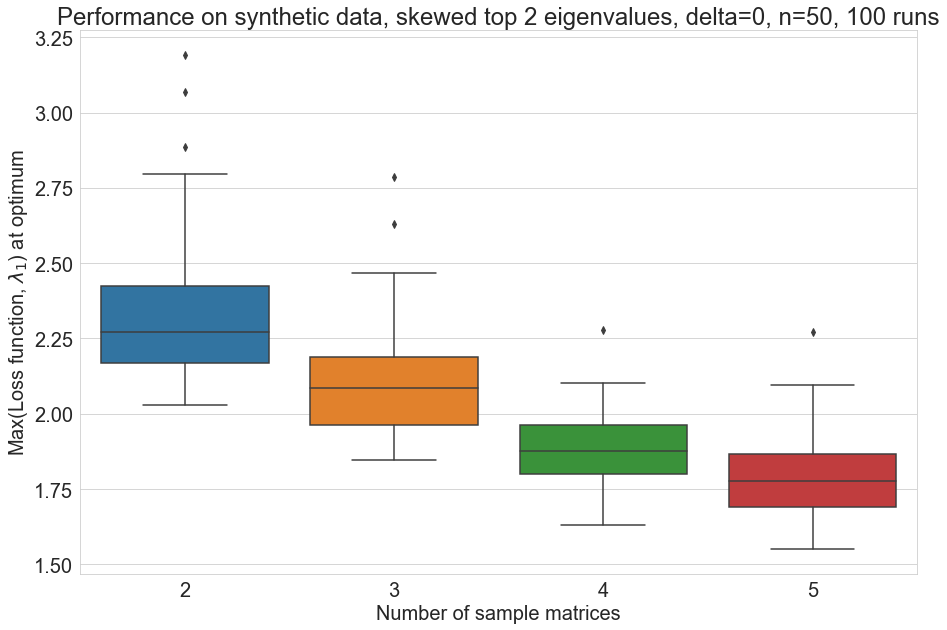

In [134]:
sns.boxplot(data=pd.DataFrame(all_scores_dict_skewed_eigs))
plt.ylabel('Max(Loss function, $\lambda_1$) at optimum')
plt.xlabel('Number of sample matrices')
plt.title('Performance on synthetic data, skewed top 2 eigenvalues, delta=0, n=50, 100 runs')
plt.savefig('figs/synthetic_data_skewed_eigs.png')

# Refine the algorithm to work at all eigenvalues

Want to compare lambda_1 only vs lambda_1 and lambda_2, etc. 

In [177]:
def obj_no_delta(mat_soln): 
    eigs = scipy.linalg.eigh(mat_soln, eigvals_only=True)
    out = 0.0
    for eig in eigs: 
        out += max(0.0, eig)
    return out

In [146]:
def true_obj(mat_soln, delta): 
    eigs = scipy.linalg.eigh(mat_soln, eigvals_only=True)
    out = 0.0
    for eig in eigs: 
        out += max(0.0, eig - delta)
    return out

In [160]:
max_obj_index = 0

def objective(eta_arr): 
    eigs = scipy.linalg.eigh(matrix_lin_combo(eta_arr, sample_mats), eigvals_only=True)
    ob_fn = lambda k: sum(eigs[-k:]) - k * delta

    all_obj_values = [ob_fn(k) for k in range(1, num_eigs_included + 1)]

    max_obj_index = np.argmax(all_obj_values)
    # print('max obj index: ', max_obj_index)
    return all_obj_values[max_obj_index]

def derivative(eta_arr): 
    eigvals, eigvecs = scipy.linalg.eigh(matrix_lin_combo(eta_arr, sample_mats))
    X_arrs_unscaled = [sample_mats[i] - sample_mats[0] if i !=0 else sample_mats[0] for i in range(len(sample_mats))]

    # list of lists 
    all_quad_forms = np.array([(eigvecs.T @ X_arrs_unscaled[i] @ eigvecs.T).sum(axis=1) for i in range(len(X_arrs_unscaled))])
    deriv_lambda_k = lambda k: all_quad_forms[:, k]

    return deriv_lambda_k(max_obj_index + 1)

In [161]:
sample_mats, ground_truth_mat, ground_truth_eigvecs = gen_data_top_2_eigs(n, m)
delta = 0.1
eta_init = np.random.uniform(0, 1, len(sample_mats))
eta_init = eta_init / np.sum(eta_init)
# ob1_bool = True 

num_eigs_included = 1
true_obj_at_k = []

for k in range(1, n + 1): 
    num_eigs_included = k
    result = scipy.optimize.minimize(
        fun=objective,
        x0=eta_init,
        method='SLSQP',
        jac=derivative,
        bounds=[(0, 1) for _ in range(len(sample_mats))],
        constraints={'type': 'eq', 'fun': simplex_constraint},
        options={
            'maxiter': 10000,
            'disp': False
        }
    )
    mat_soln = matrix_lin_combo(result['x'], sample_mats)
    print('true obj at k = ', k, ': ', true_obj(mat_soln, delta))
    true_obj_at_k.append(true_obj(mat_soln, delta))

true obj at k =  1 :  7.674593075991314
true obj at k =  2 :  7.573462473730347
true obj at k =  3 :  7.4565370159982285
true obj at k =  4 :  7.401371785900052
true obj at k =  5 :  7.533907939637199
true obj at k =  6 :  7.5835504152575135
true obj at k =  7 :  7.583838182131343
true obj at k =  8 :  7.534726875633491
true obj at k =  9 :  7.58378330192443
true obj at k =  10 :  7.180334094842418
true obj at k =  11 :  7.416642141477558
true obj at k =  12 :  7.279863720465482
true obj at k =  13 :  7.3136658731946325
true obj at k =  14 :  7.300865386450377
true obj at k =  15 :  7.3181254575671035
true obj at k =  16 :  7.186162057890753
true obj at k =  17 :  7.541330733953289
true obj at k =  18 :  7.5838171915431705
true obj at k =  19 :  7.433278456102431
true obj at k =  20 :  7.492607970064429
true obj at k =  21 :  7.338238362524358
true obj at k =  22 :  7.159772462831287
true obj at k =  23 :  7.159772462831287
true obj at k =  24 :  7.159772462831287
true obj at k =  25 :

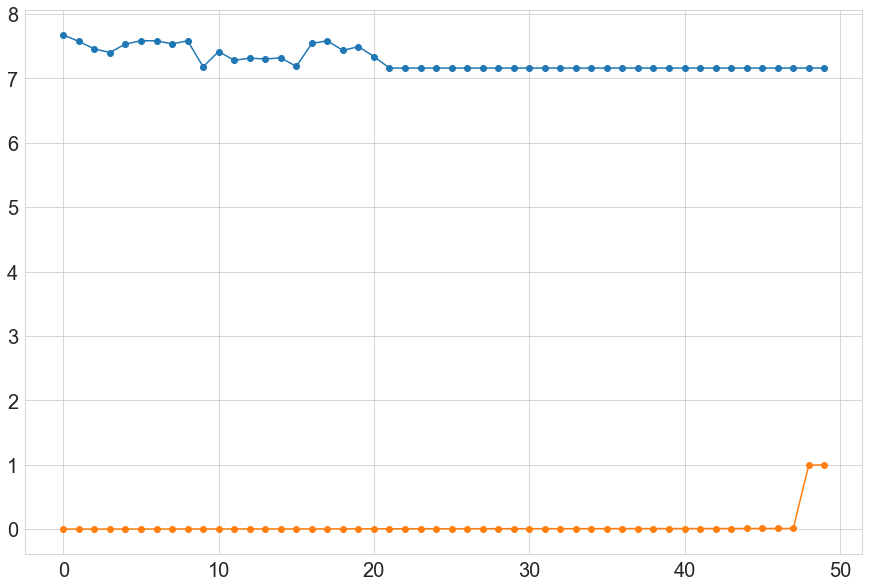

In [168]:
plt.plot(true_obj_at_k, marker='o')
plt.plot(sorted(scipy.linalg.eigh(ground_truth_mat, eigvals_only=True), reverse=False), marker='o')
# plt.ylim(5, 10)

Interesting! So the algorithm sort of stabilizes once we look at the top 20 eigenvalues or so. But it depends a lot on the initial guess.

What about different values of delta? Let's see. 

In [188]:
sample_mats, ground_truth_mat, ground_truth_eigvecs = gen_data_top_2_eigs(n, m)

eta_init = np.random.uniform(0, 1, len(sample_mats))
eta_init = eta_init / np.sum(eta_init)
# ob1_bool = True 

num_eigs_included = 1
true_obj_at_k_dict = {}

for delta in np.linspace(0.01, 0.1, 10):
    true_obj_at_k = []
    for k in range(1, n + 1): 
        num_eigs_included = k
        result = scipy.optimize.minimize(
            fun=objective,
            x0=eta_init,
            method='SLSQP',
            jac=derivative,
            bounds=[(0, 1) for _ in range(len(sample_mats))],
            constraints={'type': 'eq', 'fun': simplex_constraint},
            options={
                'maxiter': 10000,
                'disp': False
            }
        )
        mat_soln = matrix_lin_combo(result['x'], sample_mats)
        true_obj_at_k.append(obj_no_delta(mat_soln))
    print('finished delta = ', delta)
    true_obj_at_k_dict[delta] = true_obj_at_k

finished delta =  0.01
finished delta =  0.020000000000000004
finished delta =  0.030000000000000006
finished delta =  0.04000000000000001
finished delta =  0.05000000000000001
finished delta =  0.06000000000000001
finished delta =  0.07
finished delta =  0.08
finished delta =  0.09000000000000001
finished delta =  0.1


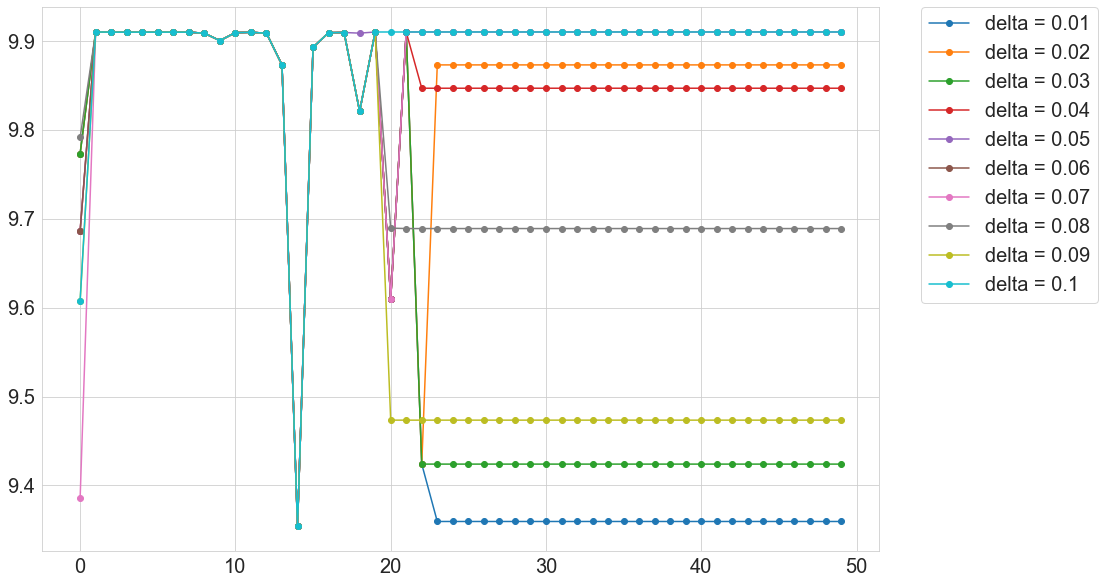

In [189]:
for delta in true_obj_at_k_dict:
    plt.plot(true_obj_at_k_dict[delta], marker='o', label='delta = ' + str(np.round(delta, 2)))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

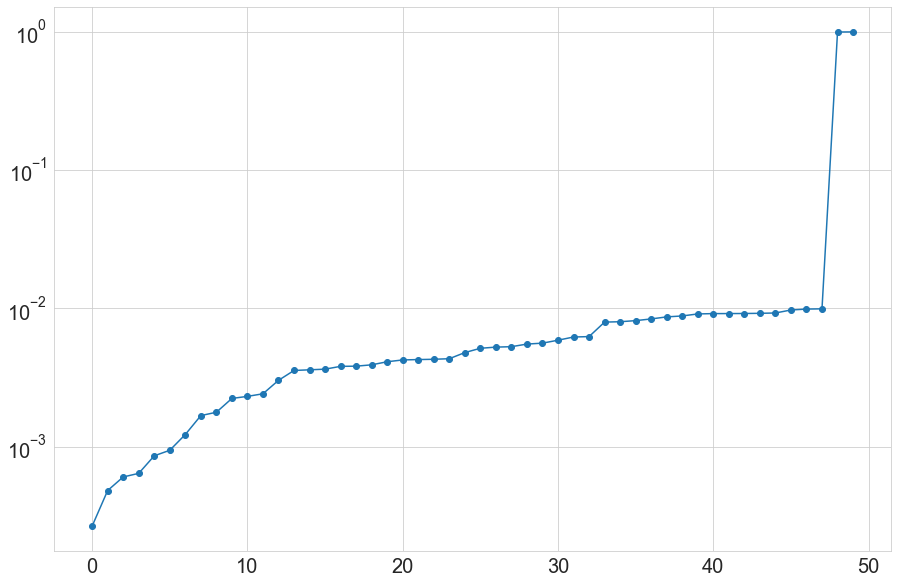

In [190]:
plt.plot(scipy.linalg.eigh(ground_truth_mat, eigvals_only=True), marker='o')
plt.yscale('log')

This is bizarre. Let's try just fixing that same matrix, and seeing if we can get reliable differences in performance when looking at 1, 2, or 3 eigenvalues. 

For the delta value, let's stick to delta=0 at first.

In [197]:
eta_init = np.random.uniform(0, 1, len(sample_mats))
eta_init = eta_init / np.sum(eta_init)

num_eigs_included = 1

delta = 0 
average_obj_at_k = []
average_obj_with_delta_at_k = []

for k in range(1, 4): 
    print(k)
    num_eigs_included = k

    average_obj_with_delta_at_k_val, obj_value_avg = 0, 0
    for _ in range(50): 
        result = scipy.optimize.minimize(
            fun=objective,
            x0=eta_init,
            method='SLSQP',
            jac=derivative,
            bounds=[(0, 1) for _ in range(len(sample_mats))],
            constraints={'type': 'eq', 'fun': simplex_constraint},
            options={
                'maxiter': 10000,
                'disp': False
            }
        )
        if result['success'] == False:
            print('failed')
        mat_soln = matrix_lin_combo(result['x'], sample_mats)
        obj_value_avg += obj_no_delta(mat_soln)
        average_obj_with_delta_at_k_val += true_obj(mat_soln, delta)
    average_obj_at_k.append(obj_value_avg / 50.0)
    average_obj_with_delta_at_k.append(average_obj_with_delta_at_k_val / 50.0)


1
2
3


In [198]:
average_obj_at_k

[9.339218475964445, 9.531454684460813, 9.05821303988499]

In [199]:
average_obj_with_delta_at_k


[9.339218475964445, 9.531454684460813, 9.05821303988499]

Of course, delta = 0 here. Let's try with a larger delta.

In [202]:
eta_init = np.random.uniform(0, 1, len(sample_mats))
eta_init = eta_init / np.sum(eta_init)

num_eigs_included = 1

delta = 0.1
average_obj_at_k = []
average_obj_with_delta_at_k = []
obj_values_scipy = []

for k in range(1, 4): 
    print(k)
    num_eigs_included = k

    average_obj_with_delta_at_k_val, obj_value_avg = 0, 0
    avg_scipy_obj = 0
    for _ in range(50): 
        result = scipy.optimize.minimize(
            fun=objective,
            x0=eta_init,
            method='SLSQP',
            jac=derivative,
            bounds=[(0, 1) for _ in range(len(sample_mats))],
            constraints={'type': 'eq', 'fun': simplex_constraint},
            options={
                'maxiter': 10000,
                'disp': False
            }
        )
        if result['success'] == False:
            print('failed')
        mat_soln = matrix_lin_combo(result['x'], sample_mats)
        obj_value_avg += obj_no_delta(mat_soln)
        average_obj_with_delta_at_k_val += true_obj(mat_soln, delta)
        avg_scipy_obj += result['fun']
    average_obj_at_k.append(obj_value_avg / 50.0)
    average_obj_with_delta_at_k.append(average_obj_with_delta_at_k_val / 50.0)
    obj_values_scipy.append(avg_scipy_obj / 50.0)


1
2
3


In [203]:
print(average_obj_at_k, average_obj_with_delta_at_k, obj_values_scipy)

[9.57320393014966, 9.57320000955325, 9.57319999262012] [7.424161146793707, 7.4241571462231954, 7.42415712894467] [0.8260176273809158, 1.5800888114367666, 2.2624784780547453]


Bizarre! Now we see worse performance at the third eigenvalue, but better at the second. Why? Shouldn't it strictly increase?

Not even the scipy objective value decreases! This at least makes sense, because as we account for more eigenvalues we get worse. 

Still, something strange is going on...

## deepay D1 and D2 idea

Create two matrices, $UD_1 U^T$ and $UD_2 U^T$ where D1, D2 have large first and second diagonal entries respectively.

In [205]:
n = 20
diag_1 = [1.0] + list(np.random.uniform(0, 0.1, n-1))
diag_2 = [np.random.uniform(0, 0.1)] + [1.0] + list(np.random.uniform(0, 0.1, n-2))

In [207]:
eigenbasis_matrix = scipy.stats.ortho_group.rvs(n)

mat1 = eigenbasis_matrix @ np.diag(diag_1) @ eigenbasis_matrix.T
mat2 = eigenbasis_matrix @ np.diag(diag_2) @ eigenbasis_matrix.T

mat = mat1 + mat2

In [208]:
scipy.linalg.eigh(mat, eigvals_only=True)

array([0.02611416, 0.03330748, 0.04241962, 0.04672013, 0.04847776,
       0.06552053, 0.06812993, 0.07733261, 0.08066907, 0.08083476,
       0.09836278, 0.10152839, 0.10291462, 0.14550343, 0.15185685,
       0.15514688, 0.16010465, 0.18561142, 1.08322835, 1.09723423])

In [209]:
sample_mats_1 = generate_sample_mats_from_mat(mat1, 5)
sample_mats_2 = generate_sample_mats_from_mat(mat2, 5)
sample_mats = sample_mats_1 + sample_mats_2